## LCC optimisation tests (for separate and joint analysis)

## Reading input data and interpolation

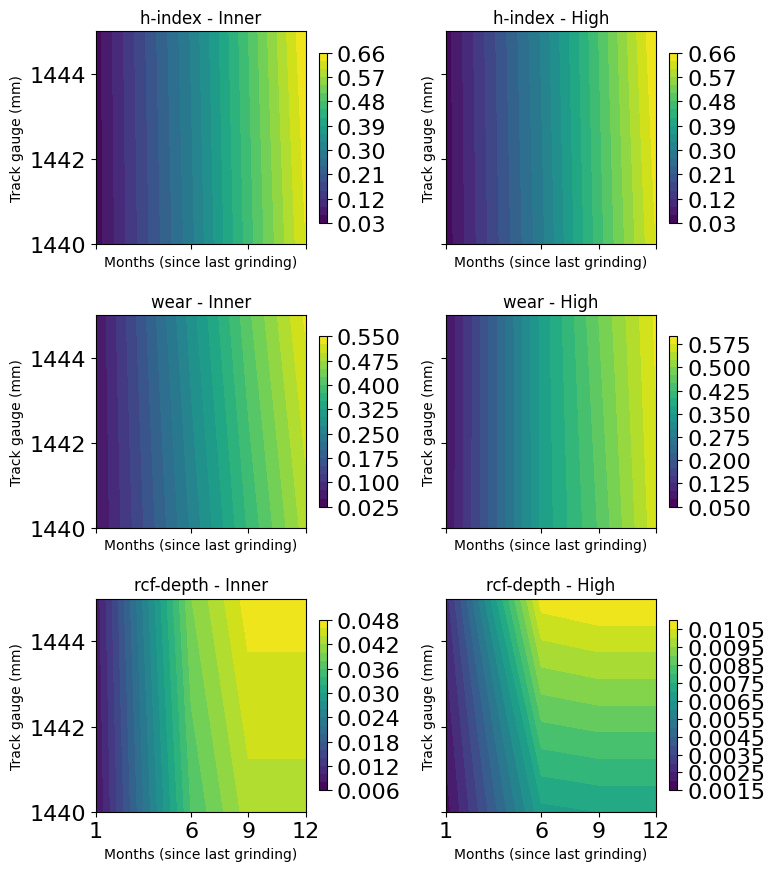

In [ ]:
# Ensure the preprocessings module is accessible
import sys
sys.path.append('../')  # Adjust the path to the root directory containing 'preprocessings'

# The actual path to the file
#file_path = '../data/raw/CM2025/BDL_111_results_JL_R1465.csv'
file_path = '../data/raw/CM2025/BDL_111_results_JL_R495.csv'

#file_path = '../data/raw/mistra_result_test_R495.csv' # example from prior project

# Import the function to read the input data
from preprocessings.read_input_data import read_input_data

# Call the function to read the data
data_df = read_input_data(file_path)

# interpolate the using interpolate_rail_data
from rail_analysis.interpolation import interpolate_rail_data
data_df_interpolated = interpolate_rail_data(data_df)

# plot the six figures using plot_six_figures
from rail_analysis.interpolation import plot_all_interpolated_tables, plot_specific_interpolated_tables
#plot_all_interpolated_tables(data_df_interpolated)
plot_specific_interpolated_tables(data_df_interpolated, ['h-index', 'wear', 'rcf-depth'])

## RCF and H-index

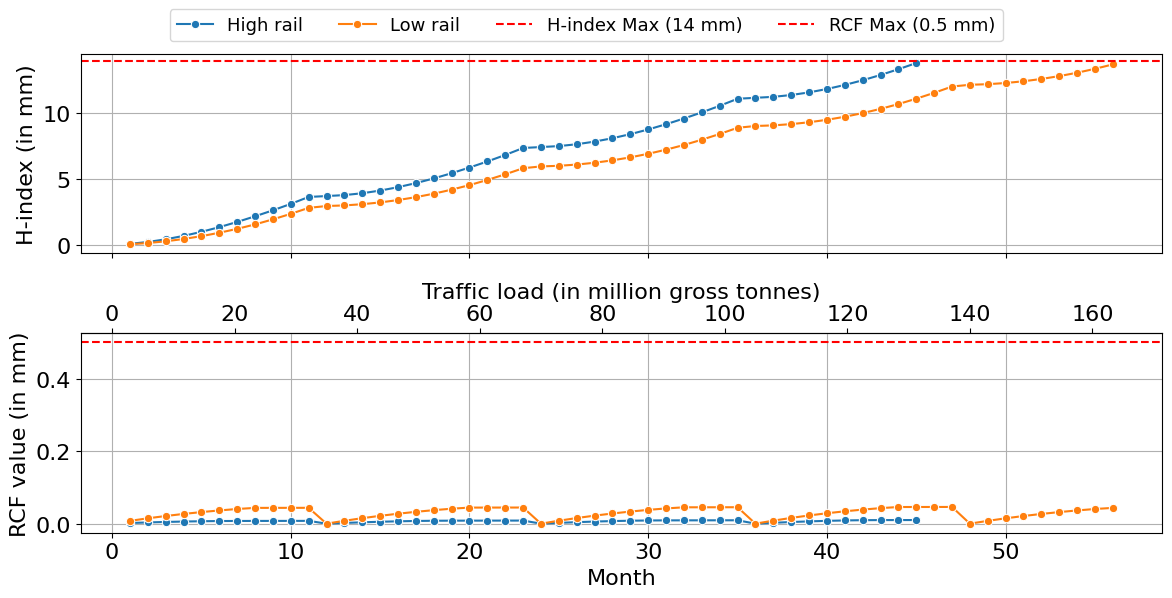

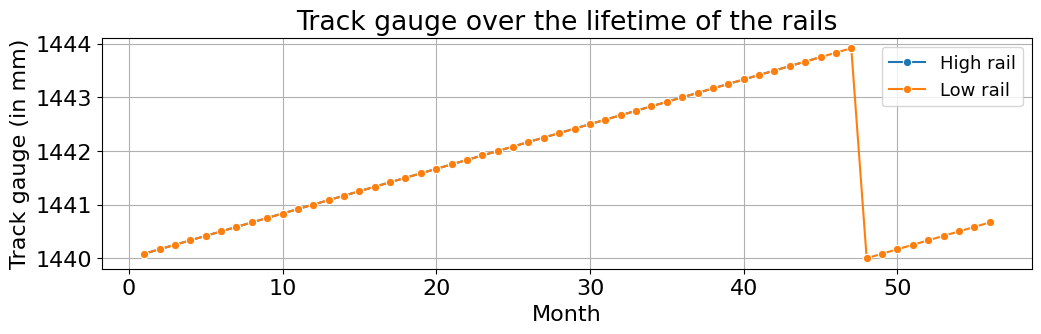

In [11]:
import matplotlib.pyplot as plt
from rail_analysis.LCC_single_rail import get_annuity_refactored, plot_historical_data_both_rails

# Choose your grinding frequency and rail
grinding_freq = 12  # e.g., 6 months
gauge_freq = 48    # or your preferred tamping frequency

# High rail
maint_strategy_high = (grinding_freq, gauge_freq)
ann_H, life_H, hist_H = get_annuity_refactored(
    data_df_interpolated,
    maint_strategy_high,
    track_results=True,
    high_or_low_rail='High'
)

# Low rail
maint_strategy_low = (grinding_freq, gauge_freq)
ann_L, life_L, hist_L = get_annuity_refactored(
    data_df_interpolated,
    maint_strategy_low,
    track_results=True,
    high_or_low_rail='Inner'
)

# Plot the history of both rails
plot_historical_data_both_rails(hist_L, hist_H)

Optimal option: Renew both @H with annuity 684.32 SEK/m/year and lifetime 23.42 years

Annuity Breakdown by Category (SEK/m/year and %):
  Renewal:   72.57 SEK/m/year (Direct: 51.14, Capacity: 21.43)  (10.6%)
  Grinding:  571.92 SEK/m/year (Direct: 311.13, Capacity: 260.79)  (83.6%)
  Tamping:   39.83 SEK/m/year (Direct: 5.47, Capacity: 34.37)  (5.8%)
  Total:     684.32 SEK/m/year


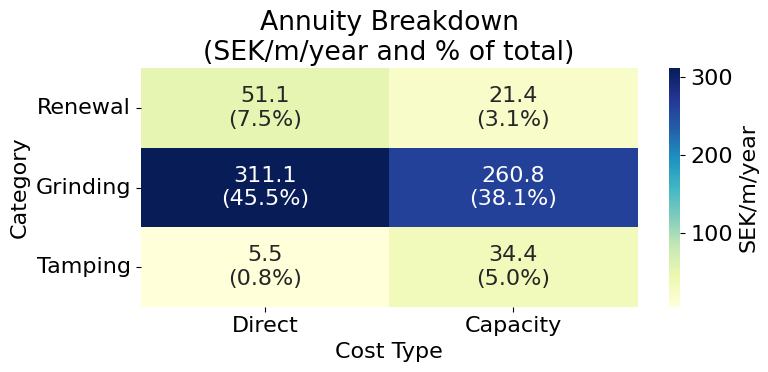

In [12]:
# get the annuity values and percentages for different cost components
from rail_analysis.LCC_two_rails import get_annuity_track_refactored

grinding_freq_low = grinding_freq_high = 3

ann_joint, life_joint, _ = get_annuity_track_refactored(
    data_df_interpolated,
    grinding_freq_low,
    grinding_freq_high,
    gauge_freq,
    verbose=True
)

    GrindingFreq  Annuity_Joint  Lifetime_Joint  TotalLCC_Joint  Annuity_High  \
0              1    1635.403467       30.000000    55999.950027   1169.086292   
1              2     857.370971       30.000000    32658.975160    602.680780   
2              3     684.324843       23.416667    27467.591325    503.192298   
3              4     739.076374       13.500000    29110.137231    536.105505   
4              5     775.499911        9.750000    30202.843360    553.523867   
5              6     813.834458        7.666667    31352.879755    568.284910   
6              7     871.470911        6.333333    33081.973363    603.006508   
7              8     938.655358        5.583333    35097.506751    646.269385   
8              9    1007.868415        4.916667    37173.898482    690.149637   
9             10    1070.809183        4.500000    39062.121522    730.902978   
10            11    1121.223194        4.166667    40574.541831    762.807433   
11            12    1115.267

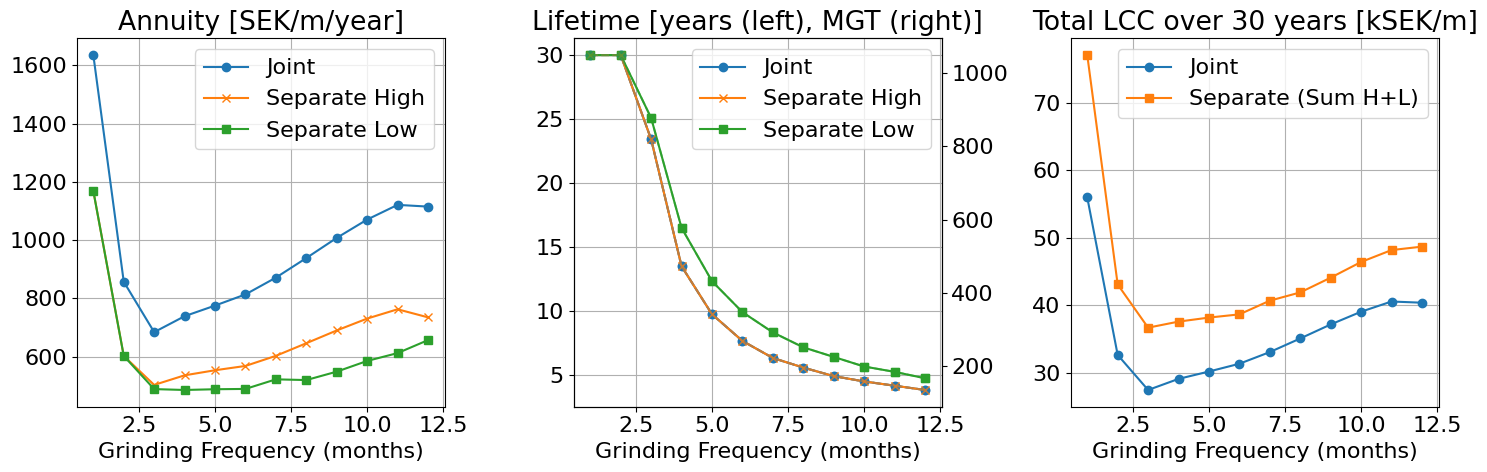

In [13]:
from rail_analysis.LCC_optimisation import compare_joint_vs_separate

# Define the range of grinding frequencies (in months) you want to test
grinding_freqs = list(range(1, 13))

# Run the comparison for these frequencies
results_df = compare_joint_vs_separate(
    data_df=data_df_interpolated,   # or your loaded/interpolated DataFrame
    grinding_freqs=grinding_freqs,
    gauge_freq=48,                  # or your preferred tamping frequency
    profile_low_rail='MB4',
    profile_high_rail='MB4',
    track_results=False,
    gauge_widening_per_year=1,
    radius='1465',
    bar_chart=True                  # Set to True to show plots
)

## Annuity and lifetime for separate high and low rail

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from rail_analysis.LCC_optimisation import run_separate_optimisation

# Define the range of grinding frequencies (in months)
grinding_freqs = list(range(1, 13))

# Prepare lists to store results
annuity_highs = []
annuity_lows = []
lifetime_highs = []
lifetime_lows = []

# Run the separate optimisation for each grinding frequency
for freq in grinding_freqs:
    ann_H, life_H, _, ann_L, life_L, _ = run_separate_optimisation(
        data_df=data_df_interpolated,
        grinding_freq=freq,
        gauge_freq=12,  # or your preferred tamping frequency
        profile_rail='MB4',
        track_results=False,
        gauge_widening_per_year=1,
        radius='1465'
    )
    annuity_highs.append(ann_H)
    annuity_lows.append(ann_L)
    lifetime_highs.append(life_H)
    lifetime_lows.append(life_L)

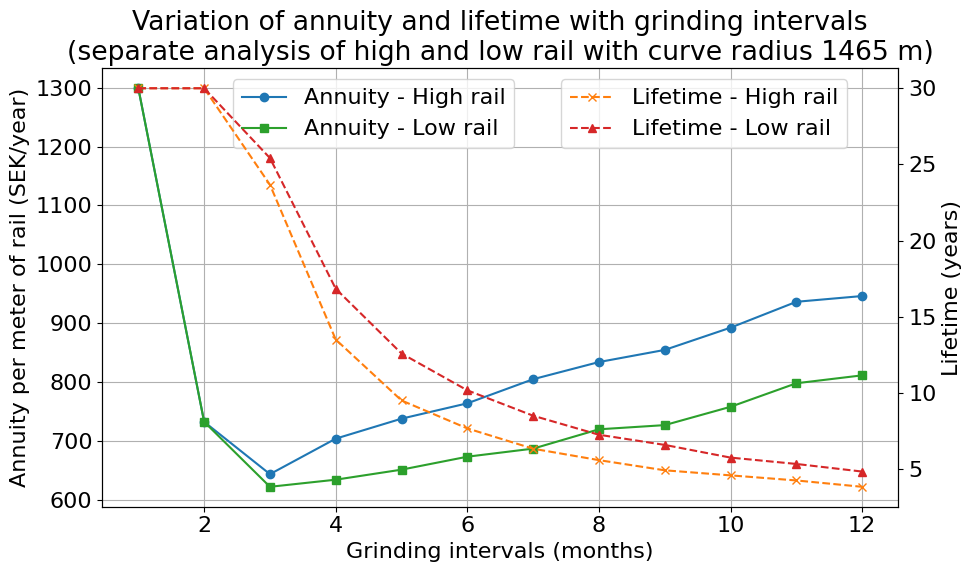

In [15]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

color_high = 'tab:blue'
color_low = 'tab:green'

ax1.set_xlabel('Grinding intervals (months)')
ax1.set_ylabel('Annuity per meter of rail (SEK/year)')
ax1.plot(grinding_freqs, annuity_highs, marker='o', color=color_high, label='Annuity - High rail')
ax1.plot(grinding_freqs, annuity_lows, marker='s', color=color_low, label='Annuity - Low rail')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left', bbox_to_anchor=(0.15, 1))
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel('Lifetime (years)')
ax2.plot(grinding_freqs, lifetime_highs, marker='x', color='tab:orange', linestyle='--', label='Lifetime - High rail')
ax2.plot(grinding_freqs, lifetime_lows, marker='^', color='tab:red', linestyle='--', label='Lifetime - Low rail')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right', bbox_to_anchor=(0.95, 1))

plt.title('Variation of annuity and lifetime with grinding intervals\n(separate analysis of high and low rail with curve radius 1465 m)')
plt.tight_layout()
plt.show()

## Heat map grinding frequency for high and low rail

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rail_analysis.LCC_optimisation import run_joint_optimisation
from rail_analysis.constants import TECH_LIFE_YEARS, TRACK_RENEWAL_COST, TRACK_LENGTH_M

# Define the range of grinding intervals (months) for high and low rail
grinding_freqs_high = list(range(1, 13))  # 1 to 12 months
grinding_freqs_low = list(range(1, 13))   # 1 to 12 months

# Prepare a 2D array to store total LCC values
lcc_matrix = np.zeros((len(grinding_freqs_low), len(grinding_freqs_high)))

# Calculate LCC for each combination
for i, freq_low in enumerate(grinding_freqs_low):
    for j, freq_high in enumerate(grinding_freqs_high):
        ann_joint, _, _ = run_joint_optimisation(
            data_df=data_df_interpolated,
            grinding_freq_low=freq_low,
            grinding_freq_high=freq_high,
            profile_low_rail='MB4',
            profile_high_rail='MB4',
            track_results=False,
            radius='1465',
        )
        # Total LCC per meter over the technical lifetime
        lcc_matrix[i, j] = ann_joint * TECH_LIFE_YEARS + TRACK_RENEWAL_COST/TRACK_LENGTH_M 

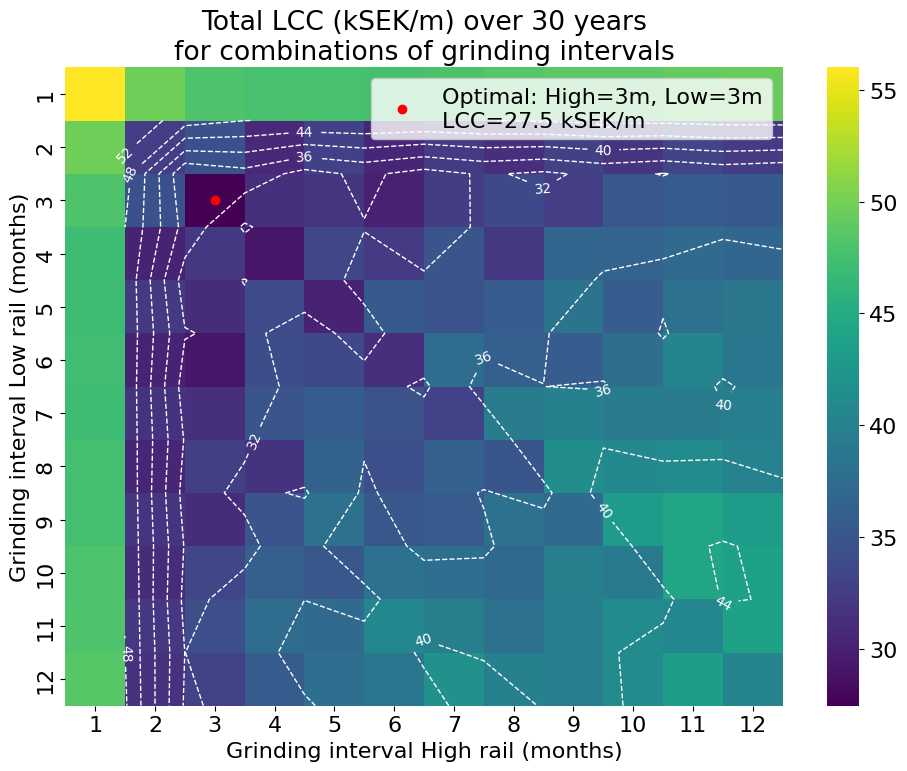

Optimal combination: High rail = 3 months, Low rail = 3 months, LCC = 27.5 kSEK/m


In [17]:
# Plot the heatmap in thousands of SEK/m, without annotations, with contours and optimal point

# Convert to thousands of SEK/m
lcc_matrix_thousands = lcc_matrix / 1000

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    lcc_matrix_thousands,
    xticklabels=grinding_freqs_high,
    yticklabels=grinding_freqs_low,
    cmap='viridis',
    annot=False
)

# Add contour lines
X, Y = np.meshgrid(grinding_freqs_high, grinding_freqs_low)
contours = plt.contour(
    X, Y, lcc_matrix_thousands, colors='white', linewidths=1, linestyles='dashed'
)
plt.clabel(contours, inline=True, fontsize=10, fmt="%.0f")

# Find optimal point (minimum LCC)
min_idx = np.unravel_index(np.argmin(lcc_matrix_thousands), lcc_matrix_thousands.shape)
opt_low = grinding_freqs_low[min_idx[0]]
opt_high = grinding_freqs_high[min_idx[1]]
opt_lcc = lcc_matrix_thousands[min_idx]

# Plot optimal point
plt.plot(opt_high - 0.5, opt_low - 0.5, 'ro', label=f'Optimal: High={opt_high}m, Low={opt_low}m\nLCC={opt_lcc:.1f} kSEK/m')
plt.legend(loc='upper right')

plt.xlabel('Grinding interval High rail (months)')
plt.ylabel('Grinding interval Low rail (months)')
plt.title(f'Total LCC (kSEK/m) over {TECH_LIFE_YEARS} years\nfor combinations of grinding intervals')
plt.tight_layout()
plt.show()

print(f"Optimal combination: High rail = {opt_high} months, Low rail = {opt_low} months, LCC = {opt_lcc:.1f} kSEK/m")

## table of the results

In [18]:
import numpy as np
from rail_analysis.LCC_single_rail import get_annuity_refactored
from rail_analysis.LCC_optimisation import run_joint_optimisation
from rail_analysis.constants import TECH_LIFE_YEARS, TRACK_RENEWAL_COST, TRACK_LENGTH_M
import pandas as pd

# Assume these optimal frequencies were determined from earlier analysis (e.g., heat map)
optimal_high = opt_high      # optimal grinding frequency for high rail (in months)
optimal_low = opt_low        # optimal grinding frequency for low rail (in months)
tamping_freq = 48            # fixed tamping frequency (in months)

# -------------------------------------------------------------------------
# Separate analysis for high and low rails (using single rail functions)
# For high rail:
maint_strategy_high = (optimal_high, tamping_freq)
ann_high_sep, life_high_sep, _ = get_annuity_refactored(
    data_df_interpolated,
    maint_strategy_high,
    high_or_low_rail='High',
    track_results=False,
    gauge_widening_per_year=1,
    radius='1465'
)
# For low rail:
maint_strategy_low = (optimal_low, tamping_freq)
ann_low_sep, life_low_sep, _ = get_annuity_refactored(
    data_df_interpolated,
    maint_strategy_low,
    high_or_low_rail='Inner',
    track_results=False,
    gauge_widening_per_year=1,
    radius='1465'
)

# -------------------------------------------------------------------------
# Joint optimization using optimal frequencies for each rail
ann_joint, life_joint, _ = run_joint_optimisation(
    data_df_interpolated,
    grinding_freq_low=optimal_low,
    grinding_freq_high=optimal_high,
    gauge_freq=tamping_freq,
    profile_low_rail='MB4',
    profile_high_rail='MB4',
    track_results=False,
    gauge_widening_per_year=1,
    radius='1465',
    track_life=TECH_LIFE_YEARS
)

# -------------------------------------------------------------------------
# Compute Lifecycle Costs (LCC) over the technical lifetime
# Separate LCC: add the LCCs for high and low rails plus track renewal (normalized per meter)
LCC_sep_high = ann_high_sep * TECH_LIFE_YEARS + TRACK_RENEWAL_COST / TRACK_LENGTH_M /2
LCC_sep_low  = ann_low_sep * TECH_LIFE_YEARS + TRACK_RENEWAL_COST / TRACK_LENGTH_M /2
LCC_sep_total = LCC_sep_high + LCC_sep_low 

# Joint LCC
LCC_joint = ann_joint * TECH_LIFE_YEARS + TRACK_RENEWAL_COST / TRACK_LENGTH_M

# Savings due to joint optimization: difference between separate and joint LCC
savings = LCC_sep_total - LCC_joint
savings_percent = 100 * savings / LCC_sep_total

# Prepare the results as a table
summary_table = pd.DataFrame({
    "Analysis": ["Separate (High Rail)", "Separate (Low Rail)", "Separate (Total)", "Joint", "Savings"],
    "Lifetime (years)": [
        life_high_sep,
        life_low_sep,
        "",  # Not applicable for total
        life_joint,
        ""
    ],
    "Annuity (SEK/m/year)": [
        ann_high_sep,
        ann_low_sep,
        "",
        ann_joint,
        ""
    ],
    f"LCC over {TECH_LIFE_YEARS} years (SEK/m)": [
        LCC_sep_high,
        LCC_sep_low,
        LCC_sep_total,
        LCC_joint,
        savings
    ],
    "Savings (%)": [
        "",
        "",
        "",
        "",
        f"{savings_percent:.2f}%"
    ]
})

# Display the table
summary_table

,Analysis,Lifetime (years),Annuity (SEK/m/year),LCC over 30 years (SEK/m),Savings (%)
0,Separate (High Rail),23.416667,503.192298,18564.691937,
1,Separate (Low Rail),25.083333,488.830246,18133.830396,
2,Separate (Total),,,36698.522333,
3,Joint,23.416667,684.324843,27467.591325,
4,Savings,,,9230.931007,25.15%
